Spatial Working Memory Implementation of (Compte et. al.)
===============================================

Modified to use simplified neuron model with a single neurotransmitter receptor type.

Excersise from the book Neuronal Dynamics From single neurons to networks and models of cognition, Chapter 18, by Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski
Detailed excersise page: https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/spatial-working-memory.html
The model has been introduced by Compte et. al. [1]. The parameters used here differ from the original paper. They are changed such that we can still study some effects while simulating a small network.
[1] Compte, A., Brunel, N., Goldman-Rakic, P. S., & Wang, X. J. (2000). Synaptic mechanisms and network dynamics underlying spatial working memory in a cortical network model. Cerebral Cortex, 10(9), 910-923.

In [1]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
#%matplotlib qt
import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#from neurodynex.working_memory_network import wm_model
#from neurodynex.working_memory_network import wm_model_modified
#from neurodynex.working_memory_network import wm_model_modified_simplified
from neurodynex.working_memory_network import wm_model_modified_simplified_EC_LV_principal

from neurodynex.tools import plot_tools

from utility_functions import *

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

from Python_Libs.utility_functions import *


Run the simulation for custom ring attractor parameters
------------------------------------------------------------------

N_excitatory=1024, N_inhibitory=256, N_extern_poisson=1000, weight_scaling_factor=2.0, stimulus_center_deg=180, stimulus_width_deg=40, stimulus_strength=70. * pamp, t_stimulus_start=0. * second, t_stimulus_duration=0. * second

In [17]:
# Useful for the optimisation of synaptic conductances 
def get_full_width_at_half_maximum_modified(values_array, circular=False, value_range=None):
    peak_idx = np.argmax(values_array) # get the index of the first max value
    max_v = np.max(values_array)       # max value in the array
    min_v = np.min(values_array)       # min value in the array
    peak_v = values_array[peak_idx]    # signal value at the peak
    half_v = (max_v - min_v) / 2       # half of the peak to peak value of the signal
    
    # We want to find the x axis width
    # Shift signal values so that at half maximum the values are 0
    values_array_shifted = values_array - half_v
    # Fit a function to the data damples in order to precisely find 0 crossing points along the x axis
    fitted_curve = interpolate.UnivariateSpline(range(len(values_array)), values_array_shifted, s=0)
    roots = fitted_curve.roots() # get the x axis points where the function crosses y=0
    # Get the nearest y=0 crossing points at the left and right of the peak
    diffs = roots - peak_idx
    
    # If the array represents elements on a circle
    if circular:
        # If only two 0 crossings and both on the same side of the peak try to correct for wrap
        if  len(diffs) == 2 and diffs[0] * diffs[1] > 0:
            max_i = np.argmax(np.abs(diffs)) # Which of the two differences is furthest away from the peak
            if max_i == 0: # In this case both 0 crossings are on the left of the peak
                diffs[max_i] =   len(values_array)-1 - peak_idx + roots[0] # Wrap the leftmost 0 crossing
            if max_i == 1: # In this case both 0 crossings are on the right of the peak
                diffs[max_i] = -(len(values_array)-1 + peak_idx - roots[1]) # Wrap the rightmost 0 crossing
        # This is an unrealistic situation where the peak is on the one end of the array only
        if len(diffs) == 1:
            diffs = np.append(diffs, -diffs[0]) # Assume symmetry
    
    # Modified these from the library version because it was not working for noisy bump. 
    # It was selecting the nearest 0 crossings now selects the farthest.
    #nearest_crossing_on_left = np.max(diffs[diffs<=0], initial=-inf)
    #nearest_crossing_on_right = np.min(diffs[diffs>=0], initial=inf)
    nearest_crossing_on_left = np.min(diffs[diffs<=0], initial=inf)
    nearest_crossing_on_right = np.max(diffs[diffs>=0], initial=-inf)
    # The distances of nearest crossing around the peak give us the FWHM
    FWHM = nearest_crossing_on_right - nearest_crossing_on_left
    
    # Convert to a number scaled to the range of values
    if value_range is not None:
        FWHM = FWHM / len(values_array) * value_range
    
    return FWHM


def get_full_width_at_half_maximum_ts_modified(values_array_of_arrays, circular=False, value_range=None):
    FWHM_list = []
    for i, values_array in enumerate(values_array_of_arrays):
        FWHM = get_full_width_at_half_maximum_modified(values_array, circular, value_range)
        FWHM_list.append(FWHM)
    
    return np.array(FWHM_list)



# Calculate spike rates
def calcSpikeRates(spike_mon,
                   N_neurons, # Number of neurons to calculate the population vector of
                   t_stimulus_start = 0 * ms, 
                   t_stimulus_duration = 500 * ms, 
                   sim_time_duration = 500. * ms, 
                   t_window_width = 200 * ms, 
                   snapshot_interval = 100 * ms):
    # Time points to sample the firing rates
    t_snapshots = range(
        int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
        int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
        int(round(snapshot_interval/ms))  # spacing between time stamps
        )*ms
    # Neurons to consider
    idx_monitored_neurons = range(0, N_neurons)
    # Calculate the population vector angle theta
    spike_rates_ts = get_spike_rates(spike_mon, idx_monitored_neurons, t_snapshots, t_window_width)
    # Create a record entry
    return (t_snapshots, spike_rates_ts)
    
    
# Calculate population vector
def calcPopulationTheta(
    spike_mon, 
    N_neurons, # Number of neurons to calculate the population vector of
    t_stimulus_start = 0 * ms, 
    t_stimulus_duration = 500 * ms, 
    sim_time_duration = 500. * ms, 
    t_window_width = 200 * ms, 
    snapshot_interval = 100 * ms):
    # Time points to sample the firing rates
    t_snapshots = range(
        int(math.floor((t_stimulus_start+t_stimulus_duration)/ms)),  # lower bound
        int(math.floor((sim_time_duration-t_window_width/2)/ms)),  # Subtract half window. Avoids an out-of-bound error later.
        int(round(snapshot_interval/ms))  # spacing between time stamps
        )*ms
    # Neurons to consider
    idx_monitored_neurons = range(0, N_neurons)
    # Calculate the population vector angle theta
    (r_ts, theta_ts) = get_theta_time_series_vec_add(spike_mon, idx_monitored_neurons, N_neurons, t_snapshots, t_window_width)
    theta_ts = np.array(theta_ts)
    return (t_snapshots, r_ts, theta_ts)

def calc_FWHM(spike_rates_ts, erroneous_samples_value=0, circular=False, value_range=None):
    FWHM_list = get_full_width_at_half_maximum_ts_modified(spike_rates_ts, circular=circular, value_range=value_range)
    if erroneous_samples_value is not None:
        FWHM_list[FWHM_list==inf] = erroneous_samples_value
        FWHM_list[FWHM_list==-inf] = erroneous_samples_value
    return FWHM_list

#def calc_objective_value():
# Calculate profile of excitatory neurons
(t_snapshots, spike_rates_ts) = calcSpikeRates(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

FWHM_list = calc_FWHM(spike_rates_ts.T, erroneous_samples_value=360, circular=True, value_range=360)

(t_snapshots, r_ts, theta_ts) = calcPopulationTheta(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

# Calculate profile of inhibitory neurons
(t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
    #spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)

FWHM_list_inhib = calc_FWHM(spike_rates_ts_inhib.T, erroneous_samples_value=0, circular=True, value_range=360)


W_desired =  55.0 # Desired bump width
W_desired_inhib = 360.0 # Desired width of inhibitory neurons activity (all active)
H_desired = 180.0 # Desired bump angle
A_desired = 10    # Desired bump min amplitude

# Measure the bump characteristics after the stimulus
spike_rates_mean = np.mean(spike_rates_ts/Hz, axis=1)
peak2peak = np.max(spike_rates_mean) - np.min(spike_rates_mean)
e_W_all = np.abs(W_desired - np.mean(FWHM_list))/ 360
e_W_all_inhib = np.abs(W_desired_inhib - np.mean(FWHM_list_inhib))/ 360
e_H_all = np.abs(H_desired - np.mean(theta_ts)) / 360
#e_A_all = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
e_A_all = 1. / (1. + peak2peak)

spike_rates_mean_all_inhib = np.mean(spike_rates_ts_inhib)
e_S_all_inhib = 1. / (1. + spike_rates_mean_all_inhib/Hz)
e_S_all_inhib_2 = 2*(1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1]))-1

# Measure the bump characteristics two time snapshot windows before the last
t_snapshots[len(t_snapshots)-3]
spike_rates_mean_2 = (spike_rates_ts/Hz).T[len(t_snapshots)-3]
peak2peak_2 = np.max(spike_rates_mean_2) - np.min(spike_rates_mean_2)
e_W_2 = np.abs(W_desired - FWHM_list[len(t_snapshots)-3])/ 360
e_H_2 = np.abs(H_desired - theta_ts[len(t_snapshots)-3]) / 360
e_A_2 = 1. / (1. + peak2peak_2)

# Measure how much does the bump width change
W_diff = (np.mean(FWHM_list[len(t_snapshots)-50:len(t_snapshots)-40]) - np.mean(FWHM_list[len(t_snapshots)-213:len(t_snapshots)-203])) / 360

#fitness_error = 4*e_W_all + e_H_all + e_A_all
#fitness_error = 5 * (e_W_all + e_W_2 + e_W_all_inhib) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2
fitness_error = 5 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2 + W_diff

#plot(t_snapshots/ms, theta_ts)
#plot(t_snapshots/ms, FWHM_list)
#plot(t_snapshots_inhib/ms, FWHM_list_inhib)
#plot(rate_monitor_inhib.t/ms, rate_monitor_inhib.smooth_rate(width=25 * ms) / Hz)
#plot(t_snapshots_inhib/ms, np.mean(spike_rates_ts_inhib, axis=0)/Hz)

#plot(spike_rates_ts.T[0])
#spike_rates_ts.shape
#FWHM_list.shape
#np.mean(FWHM_list)
#np.mean(theta_ts)
#np.mean(FWHM_list_inhib)
#np.mean(spike_rates_ts_inhib)
#len(spike_rates_ts.T)
print('fitness_error={} \n e_W_all={} \n e_H_all={} \n e_A_all={} \n e_W_2={} \n e_H_2={} \n e_A_2={} \n %e_W_all_inhib={} \n e_S_all_inhib_2={} \n W_diff={}'.format(fitness_error, e_W_all, e_H_all, e_A_all, e_W_2, e_H_2, e_A_2, e_W_all_inhib, e_S_all_inhib_2, W_diff))
#return fitness_error

#fitness = calc_objective_value()

fitness_error=1.24572376844 
 e_W_all=0.124303860285 
 e_H_all=0.000405111822229 
 e_A_all=0.0263202199899 
 e_W_2=0.114943629108 
 e_H_2=0.00193407198929 
 e_A_2=0.0196078431373 
 %e_W_all_inhib=1.0 
 e_S_all_inhib_2=0.0 
 W_diff=0.00121907453187


In [18]:
print('Mean bump width', np.mean(FWHM_list[int(len(t_snapshots)/2):len(t_snapshots)-3]))

Mean bump width 97.89417996375039


In [60]:
W_diff = (np.mean(FWHM_list[len(t_snapshots)-50:len(t_snapshots)-40]) - np.mean(FWHM_list[len(t_snapshots)-213:len(t_snapshots)-203])) / 360
W_diff

0.002326621841482337

In [142]:
def calc_objective_value(
    spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = 100*ms, 
    t_stimulus_duration = 200*ms, 
    sim_time_duration = 500. * ms,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms, 
    W_desired =  60,       # Desired bump width
    W_desired_inhib = 360, # Desired width of inhibitory neurons activity (all active)
    H_desired = 180,       # Desired bump angle
    A_desired = 10         # Desired bump min amplitude
    ):
    # Calculate profile of excitatory neurons
    (t_snapshots, spike_rates_ts) = calcSpikeRates(
        spike_monitor_excit, N_excitatory, 
        #spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    FWHM_list = calc_FWHM(spike_rates_ts.T, erroneous_samples_value=360, circular=True, value_range=360)

    (t_snapshots, r_ts, theta_ts) = calcPopulationTheta(
        spike_monitor_excit, N_excitatory, 
        #spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    # Calculate profile of inhibitory neurons
    (t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
        #spike_monitor_excit, N_excitatory, 
        spike_monitor_inhib, N_inhibitory, 
        t_stimulus_start = t_stimulus_start, 
        t_stimulus_duration = t_stimulus_duration, 
        sim_time_duration = sim_time_duration,
        t_window_width = t_window_width, 
        snapshot_interval = snapshot_interval)

    FWHM_list_inhib = calc_FWHM(spike_rates_ts_inhib.T, erroneous_samples_value=0, circular=True, value_range=360)

    # Measure the bump characteristics after the stimulus
    spike_rates_mean = np.mean(spike_rates_ts/Hz, axis=1)
    peak2peak = np.max(spike_rates_mean) - np.min(spike_rates_mean)
    e_W_all = np.abs(W_desired - np.mean(FWHM_list))/ 360
    e_W_all_inhib = np.abs(W_desired_inhib - np.mean(FWHM_list_inhib))/ 360
    e_H_all = np.abs(H_desired - np.mean(theta_ts)) / 360
    #e_A_all = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
    e_A_all = 1. / (1. + peak2peak)
    
    spike_rates_mean_all_inhib = np.mean(spike_rates_ts_inhib)
    e_S_all_inhib = 1. / (1. + spike_rates_mean_all_inhib/Hz)
    #e_S_all_inhib_2 = 1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1])
    e_S_all_inhib_2 = 2*(1. / (1. + sum((np.mean(spike_rates_ts_inhib, axis=0)/Hz) > 30)/spike_rates_ts_inhib.shape[1]))-1
    
    # Measure the bump characteristics two time snapshot windows before the last
    t_snapshots[len(t_snapshots)-3]
    spike_rates_mean_2 = (spike_rates_ts/Hz).T[len(t_snapshots)-3]
    peak2peak_2 = np.max(spike_rates_mean_2) - np.min(spike_rates_mean_2)
    e_W_2 = np.abs(W_desired - FWHM_list[len(t_snapshots)-3])/ 360
    e_H_2 = np.abs(H_desired - theta_ts[len(t_snapshots)-3]) / 360
    e_A_2 = 1. / (1. + peak2peak_2)

    #fitness_error = 4*e_W_all + e_H_all + e_A_all
    #fitness_error = 5 * (e_W_all + e_W_2 + e_W_all_inhib) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2
    fitness_error = 5 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2 + e_S_all_inhib_2*2 + W_diff
    return fitness_error

fitness_error_1 = calc_objective_value(
    spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms, 
    W_desired =  W_desired,            # Desired bump width
    W_desired_inhib = W_desired_inhib, # Desired width of inhibitory neurons activity (all active)
    H_desired = H_desired,             # Desired bump angle
    A_desired = A_desired              # Desired bump min amplitude
)
print(fitness_error_1)

1.2535241111054976


84.48546935614745

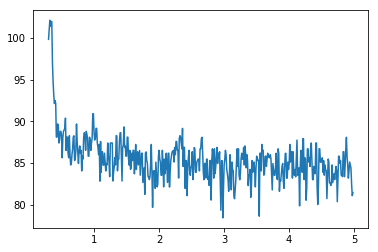

In [54]:
plot(t_snapshots, FWHM_list)
np.mean(FWHM_list[int(len(t_snapshots)/2.0):len(t_snapshots)-3])
#len(t_snapshots)

In [55]:
FWHM_list[len(t_snapshots)-3]

82.4721926342093

In [56]:
#rate_monitor_inhib # is 0
rate_monitor_inhib.smooth_rate(width=10 * ms) / Hz

array([ 0.        ,  0.        ,  0.        , ..., 29.44749725,
       29.33472834, 29.21096236])

In [57]:
np.mean(spike_rates_ts_inhib, axis=0)/Hz

array([99.12109375, 51.953125  , 50.68359375, 97.36328125, 50.390625  ,
       50.390625  , 55.6640625 , 50.48828125, 82.71484375, 51.07421875,
       60.546875  , 52.44140625, 51.07421875, 56.8359375 , 51.85546875,
       73.73046875, 52.63671875, 64.84375   , 53.61328125, 52.24609375,
       54.58984375, 53.22265625, 61.328125  , 54.00390625, 65.4296875 ,
       53.41796875, 61.81640625, 53.515625  , 55.46875   , 54.78515625,
       54.296875  , 57.12890625, 53.41796875, 68.45703125, 53.125     ,
       59.66796875, 53.41796875, 57.03125   , 55.2734375 , 54.8828125 ,
       57.91015625, 54.00390625, 58.7890625 , 54.296875  , 64.2578125 ,
       54.6875    , 58.69140625, 54.1015625 , 55.2734375 , 54.58984375,
       55.46875   , 60.3515625 , 54.00390625, 60.3515625 , 52.83203125,
       63.28125   , 53.3203125 , 56.54296875, 55.6640625 , 53.90625   ,
       58.49609375, 53.02734375, 58.984375  , 53.61328125, 66.11328125,
       54.8828125 , 59.27734375, 53.7109375 , 54.19921875, 54.98

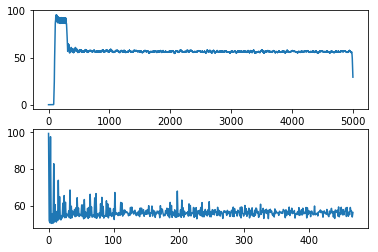

In [58]:
subplot(211)
plot(rate_monitor_inhib.t/ms, rate_monitor_inhib.smooth_rate(width=10 * ms) / Hz)
subplot(212)
plot(np.mean(spike_rates_ts_inhib, axis=0)/Hz)

In [15]:
from mpl_toolkits.mplot3d import Axes3D
Y = np.arange(0, spike_rates_ts_inhib.shape[0], 1)
X = np.arange(0, spike_rates_ts_inhib.shape[1], 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, spike_rates_ts_inhib)

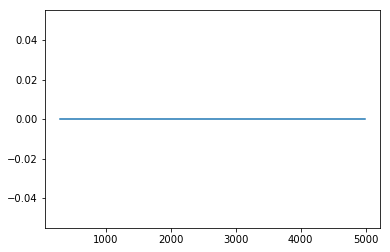

In [29]:
#plot(rate_monitor_excit.t/ms, rate_monitor_excit.smooth_rate(width=25 * ms) / Hz)
#for index4 in range(spike_rates_ts.shape[0]):
#    plot(t_snapshots/ms, spike_rates_ts[index4]/Hz)
plot(t_snapshots/ms, spike_rates_ts[255]/Hz)

Text(0.5,0,u'Time (ms)')

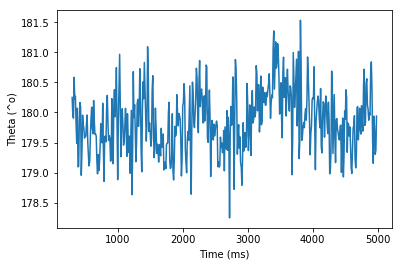

In [19]:
plot(t_snapshots/ms, theta_ts)
ylabel('Theta (^o)')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b7a7310>)

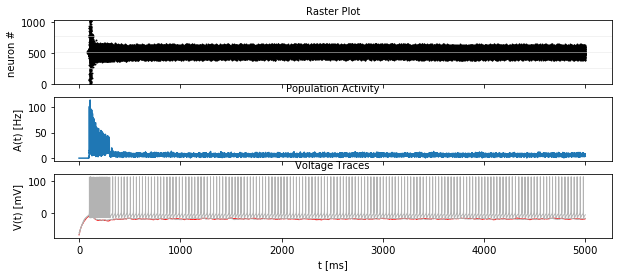

In [10]:
# The one with the EC Layer V neurons
# Run with unstructured Poisson input of higher impulse rate (all neurons receive similar activity)
sim_time_duration    = 500. * ms
t_stimulus_start     = 100*ms
t_stimulus_duration  = 200*ms
stimulus_center_deg  = 180
stimulus_width_deg   = 40
N_excitatory         = 1024
N_inhibitory         = 256
#N_excitatory         = 512
#N_inhibitory         = 128
#N_excitatory         = 4096
#N_inhibitory         = 1024
N_excitatory         = 2048
N_inhibitory         = 512
weight_scaling_factor= 1.0
sigma_weight_profile = 20.
stimulus_strength    = 0.07 * namp
stimulus_strength    = 0.5 * namp
poisson_firing_rate  = 2.3 * Hz
Jpos_excit2excit     = 1.6

##sigma_weight_profile = 0.34
#weight_scaling_factor= 1.

G_inhib2inhib        = 3. * nS  # 0.3584 * nS #* 0.
G_inhib2inhib        = 0.5*nS #3. * nS  # 0.3584 * nS #* 0.

G_inhib2excit        = 2 * nS  # 0.4676 * nS #* 4.
G_inhib2excit        = 0.5 * nS  # 0.4676 * nS #* 4.

G_excit2excit        = 6. * nS  # 0.13335 * nS# / 2.
G_excit2excit        = 0.5 * nS  # 0.13335 * nS# / 2.

G_excit2inhib        = 12.* nS  # 0.12264 * nS * 98 # = 12nS
G_excit2inhib        = 2.* nS  # 0.12264 * nS * 98 # = 12nS

G_extern2excit       = 24*nS  # = we # 3.1 * nS # was we=6nS


# scipy.optimize.minimize SLSQP
# fitness: 0.6527777777777778: [50.09647318,  163.09337616,  142.89327785, 4039.3909614, 42.08445722] fitness = e_W + e_H
# fitness: 0.6527777777777778: [19107.22914158, 46141.12118672,  8194.23859763, 22931.76914411, 52354.85598259] fitness = e_W + e_H
# fitness: 1.662777777777778: [3.90674420e+01, 6.41396973e+03, 2.40158152e+01, 1.28865870e+00, 2.09827934e+03] fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
# fitness: 0.2473953940935857 [1.09667969, 1.09667969, 0.99902344, 1.09667969, 1.09667969] fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 0.6044482471532799 [1., 1., 1., 1., 1.] (equal to initial values) Does not succeed in finding a solution: 'Positive directional derivative for linesearch' fitness_error = 4*e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 2.474881805844937 [1., 1., 1., 1., 1.] (equal to initial values) Does not succeed in finding a solution: 'Inequality constraints incompatible' fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2
# Failed even on the simulate_wm with x0 the working parameters. 'Positive directional derivative for linesearch'

# scipy.optimize.minimize TNC
# fitness: 0.19532565528050483: [1., 1., 1., 1., 1.] (equal to initial values) fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
# fitness: 0.3979377463075265: [1.00000001, 0.99999992, 0.99999998, 0.99999984, 0.99999989] fitness_error = 4*e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: 3.027985852863991 [1., 1., 1., 1., 1.] 'Linear search failed' fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2
# Converged on simulate_wm with x0 the working parameters fitness: 7.045451451040202 [0.3584 , 0.4676 , 0.13335, 0.12264, 3.1] 'Converged (|x_n-x_(n-1)| ~= 0)' Essentially changed only the penultimate parameter rounding it to 0.1226
# Converged on simulate_wm with x0 the working parameters fitness: 7.045451451040202 [0.5    , 0.4676 , 0.13335, 0.12264, 3.1] 'Converged (|x_n-x_(n-1)| ~= 0)' Essentially did not change the altered parameter and kept it to 0.5 

# scipy.optimize.dual_annealing 
# fitness: waiting fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness:  fitness_error = 4*e_W + e_H + e_A
# fitness:  fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2

# scipy.optimize.basinhopping 
# fitness:  fitness = e_W + e_H + e_A, e_A = (int(peak2peak < A_desired) * np.abs(A_desired+0.1 - peak2peak))/10.0
#    N_excitatory         = 512
#    N_inhibitory         = 128
# fitness: waiting fitness = e_W + e_H + e_A, e_A = 1. / (1. + peak2peak)
# fitness: fitness_error = 4*e_W + e_H + e_A
# fitness:  fitness_error = 4 * (e_W_all + e_W_2) + e_H_all + e_H_2 + e_A_all + e_A_2

stimulus_strength    = 2 * namp
Jpos_excit2excit     = 1.6
#weight_scaling_factor= 1.
# Optimised for 512/128
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array([0.86635697,  3.7267002,  66.12077086, 14.73296054,  7.64443366]) * nS
# Optimised for 512/128 scalled for 2048/512
G_inhib2inhib         = 0.21658924 * nS # 0.86635697  / 4.
G_inhib2excit         = 0.93167505 * nS # 3.7267002   / 4.
G_excit2excit         = 16.5301927 * nS # 66.12077086 / 4.
G_excit2inhib         = 3.68324014 * nS # 14.73296054 / 4.
g_coop                = 0.0 * nS  # Does not need scaling


# Optimised for 64/16
# N_excitatory         = 64
# N_inhibitory         = 16
# weight_scaling_factor= 
# Preference 

# Optimised for 128/32
# N_excitatory         = 128
# N_inhibitory         = 32
# weight_scaling_factor= 
# Preference 

# Optimised for 256/64
# N_excitatory         = 256
# N_inhibitory         = 64
poisson_firing_rate  = 2.3 * Hz
stimulus_strength    = 2 * namp 
weight_scaling_factor= 1.0
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0, 0.0, 0.0, 0.0]) * nS
# Preference 1 original with scaling 2 (wider bump) or 2 original with scaling 4 (thinner bump and maybe shaking bump borders)

# Optimised for 512/128
# N_excitatory         = 512
# N_inhibitory         = 128
# poisson_firing_rate  = 2.3 * Hz
# stimulus_strength    = 2 * namp 
# weight_scaling_factor= 1.0
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([ 68.66505563, 791.47713452, 171.14663483, 298.23024137]) * nS
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array() * nS
# Preference 

# Optimised for 1024/256
# N_excitatory         = 1024
# N_inhibitory         = 256
# weight_scaling_factor= 1. # 
# #stimulus_strength    = 2 * namp 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# Preference 

# Optimised for 2048/512
# N_excitatory         = 2048
# N_inhibitory         = 512
# weight_scaling_factor= 1.
# #stimulus_strength    = 2 * namp 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# Preference 

# # Optimised for 4096/1024
# N_excitatory         = 4096
# N_inhibitory         = 1024
# weight_scaling_factor= 1.
# #stimulus_strength    = 2 * namp 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# Preference 

# # Optimised for 8192/2048
# N_excitatory         = 8192
# N_inhibitory         = 2048
# weight_scaling_factor= 1.
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, g_coop = np.array()
# Preference 

# Hand tuned solution
N_excitatory         = 2048
N_inhibitory         = 512
weight_scaling_factor= 1. 
poisson_firing_rate  = 2.3 * Hz
G_extern2excit       = 1.0 * nS  # = we # 3.1 * nS # was we=6nS
stimulus_strength    = 1 * namp 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0001, 0.005, 0.3, 1.0]) * nS # Hand tuned solution f = 0.9171 0.0846988690326 81deg [0] 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.000403700359, 0.005, 0.3, 1.0]) * nS # f = 0.9033526921043727 1.00775243291 87deg [1]
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0004, 0.005, 0.3, 1.0]) * nS # f = 0.949117882375 87deg [1b] the optimized from [1] with simplified the first factor
# [0] fitness_error=0.892228024007  e_W_all=0.0846988690326  e_H_all=0.00674831384286  e_A_all=0.0300275305717  e_W_2=0.0806919021774  e_H_2=0.00879478075343  e_A_2=0.0196078431373  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=9.56996514269e-05
# [1] fitness_error=1.00775243291  e_W_all=0.0923302452307  e_H_all=0.0107250481  e_A_all=0.0290960977728  e_W_2=0.0943665090175  e_H_2=0.01190901781  e_A_2=0.0196078431373  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=0.00293065485155
# [1b] fitness_error=0.949117882375  e_W_all=0.0916588345851  e_H_all=0.00248663985262  e_A_all=0.0291866326467  e_W_2=0.0865655377301  e_H_2=0.00705057435597  e_A_2=0.0196078431373  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=-0.000335669193718
# Preferred: [1b] with factor=1. even though [0] and [1] are equally good

# N_excitatory         = 1024
# N_inhibitory         = 256
# weight_scaling_factor= 2. # f = 0.42879657466 0.422574932228 0.433169656631 70deg [1] with factor=2. better than below
# Preferred: [1] with factor=2. or [3] or [2]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00110782807, 0.005, 0.3, 4.63132509]) * nS # f = 0.7537300285404933 0.775671039548 0.968770554762 80deg [2] Looks more noisy at the edges of the bump than the above 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00596382, 0.04, 4.42693812, 2.86773382]) * nS # f = 0.45480675728873865 0.469669742252 70deg [3] More stable bump theta than [2]

# N_excitatory         = 512
# N_inhibitory         = 128
# weight_scaling_factor= 3. # f = 1.11975836891 1.19895569942 1.27739739038 94deg [1] with factor=3. sharper bump edge and a bit moe stable theta than [2]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0000861990726, 0.0357004628, 3.26601664, 4.88193990]) * nS # f = 0.47188205308016057 0.518183966974 72deg [2] More fuzzy bump borders than [1] with factor=3. 
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.0000861990726, 0.0357004628, 3.24396393, 4.88193990]) * nS # f = 0.37661339814094436 0.400587023923 0.429100649275 68deg [3] More fuzzy bump borders than [1] with factor=3. 
# Preferred: [3] and [2]

# N_excitatory         = 256
# N_inhibitory         = 64
# # weight_scaling_factor= 4. # f = 4.45857790363 Too wide bump
# # weight_scaling_factor= 4.5 # f = 2.24758238088 Still wide bump
# # weight_scaling_factor= 4.75 # f = 1.60581013558 Better bump width
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00545939215, 0.04, 3.40815238, 8.32985526]) * nS # f = 1.1422236025542827 [2]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00126610809, 0.04, 3.4, 8.0]) * nS # f = 0.9611533533082731 [3]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00215650131, 0.04, 3.4, 8.0]) * nS # f = 0.7186272437789766 1.07315602095 1.02780169514 89deg [4]
# G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.00210380550, 0.04, 3.4, 8.0]) * nS # f = 0.8718980028904659 1.0154054308 91deg [5]
# Preferred: [5]

# [4] fitness_error=1.02780169514  e_W_all=0.100181743978  e_H_all=0.0116878891209  e_A_all=0.0197315831545  e_W_2=0.0972222222222  e_H_2=0.00179812582233  e_A_2=0.00990099009901  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=-0.00233672405356
# [5] fitness_error=0.9346864556  e_W_all=0.100434564497  e_H_all=0.000528179593111  e_A_all=0.019690163315  e_W_2=0.0739612038395  e_H_2=0.0236840459738  e_A_2=0.0196078431373  %e_W_all_inhib=1.0  e_S_all_inhib_2=0.0  W_diff=-0.000802618099903
    
# N_excitatory         = 4096
# N_inhibitory         = 1024
# weight_scaling_factor= 0.5 # 95deg
# Preferred: [1] with factor=0.5

# N_excitatory         = 8192
# N_inhibitory         = 2048
# -weight_scaling_factor= 0.25 # f = 1.24572376844 98deg
# Preferred: [1] with factor=0.25

# Good solution N_excitatory         = 512; N_inhibitory         = 128; poisson_firing_rate  = 0.0 * Hz; G_extern2excit       = 1.0 * nS; stimulus_strength    = 2 * namp; G_extern2excit       = 24*nS; G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([5.60696855e-04, 7.32401796e-02, 6.18100348e+00, 7.38110213e+0]) * nS; # fitness = 0.14000185292069822

# For the current tested case 
sim_time_duration    = 5000. * ms
#python3 optimize_synaptic_conductances.py dual_annealing simple 512 128 2.3 1.0 1.0
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([1.00000000e-04, 5.00000000e-03, 1.44523877e+00, 4.28769660e+00]) * nS
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([1.00000000e-04, 5.00000000e-03, 1.47677173e+00, 4.28769660e+00]) * nS
#G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib = np.array([0.67939525, 0.005,      0.3,        1.]) * nS

# Normal model
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_EC_LV_Principal_Neurons_reduced_2(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)


Text(0.5,0,u'Time (ms)')

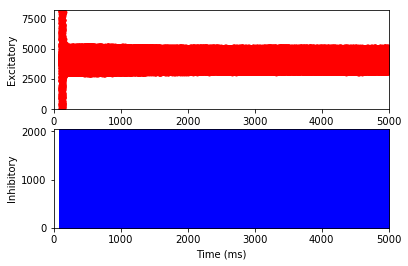

In [14]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
xlim([0,sim_time_duration/ms])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
xlim([0,sim_time_duration/ms])
ylabel('Inhibitory')
xlabel('Time (ms)')

Text(0.5,0,u'Time (ms)')

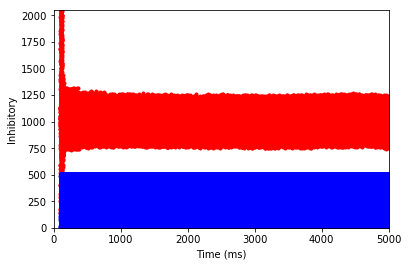

In [32]:
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
xlim([0,sim_time_duration/ms])
ylabel('Excitatory')
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylabel('Inhibitory')
xlabel('Time (ms)')

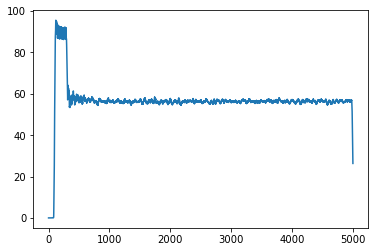

In [33]:
plot(rate_monitor_inhib.t/ms, rate_monitor_inhib.smooth_rate(width=10 * ms) / Hz)

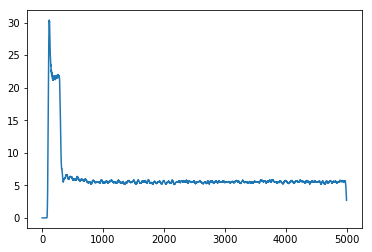

In [34]:
plot(rate_monitor_excit.t/ms, rate_monitor_excit.smooth_rate(width=10 * ms) / Hz)

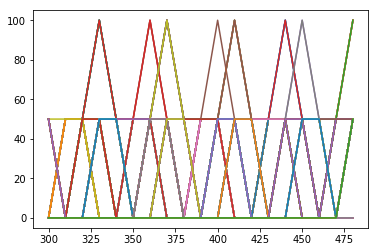

In [226]:
# Calculate profile of excitatory neurons
(t_snapshots, spike_rates_ts) = calcSpikeRates(
    spike_monitor_excit, N_excitatory, 
    #spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)
for index1 in range(len(spike_rates_ts)): 
    if count_nonzero(spike_rates_ts[index1]/Hz) > 0:
        #print(index1)
        plot(t_snapshots/ms, spike_rates_ts[index1]/Hz)

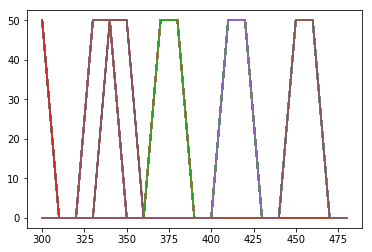

In [227]:
# Calculate profile of inhibitory neurons
(t_snapshots_inhib, spike_rates_ts_inhib) = calcSpikeRates(
    #spike_monitor_excit, N_excitatory, 
    spike_monitor_inhib, N_inhibitory, 
    t_stimulus_start = t_stimulus_start, 
    t_stimulus_duration = t_stimulus_duration, 
    sim_time_duration = sim_time_duration,
    t_window_width = 20 * ms, 
    snapshot_interval = 10 * ms)
for index1 in range(len(spike_rates_ts_inhib)): 
    if count_nonzero(spike_rates_ts_inhib[index1]/Hz) > 0:
        plot(t_snapshots_inhib/ms, spike_rates_ts_inhib[index1]/Hz)

(-10, 20)

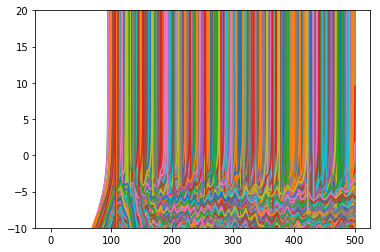

In [212]:
for index2 in range(len(voltage_monitor_excit.v)):
    plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[index2]/mV)
ylim([-10,20])

(-40, 20)

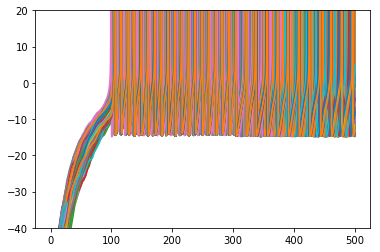

In [213]:
for index2 in range(len(voltage_monitor_inhib.v)):
    plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[index2]/mV)
ylim([-40,20])

In [35]:
#for index3 in range(0, len(voltage_monitor_excit.O_coop), 10):
#    plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.O_coop[index3])
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.O_coop[255]) # 214-298 100 until the end. Down to 207 and Up to 302 interminent

AttributeError: No attribute with name O_coop

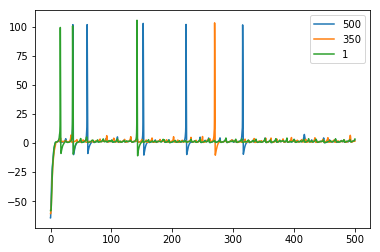

In [22]:
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[500]/mV, label='500')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[350]/mV, label='350')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit.v[1]/mV, label='1')
legend()
#ylim([-0.030, 0.01])

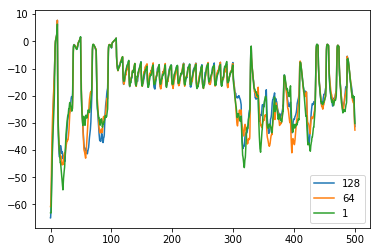

In [35]:
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[127]/mV, label='128')
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[64]/mV, label='64')
plot(voltage_monitor_inhib.t/ms, voltage_monitor_inhib.v[1]/mV, label='1')
legend()

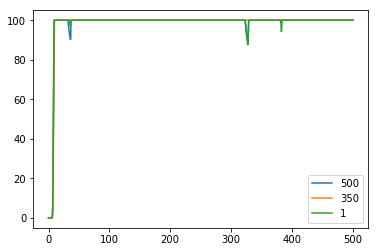

In [36]:
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[500].O_coop, label='500')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[350].O_coop, label='350')
plot(voltage_monitor_excit.t/ms, voltage_monitor_excit[1].O_coop, label='1')
legend()

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127f26390>)

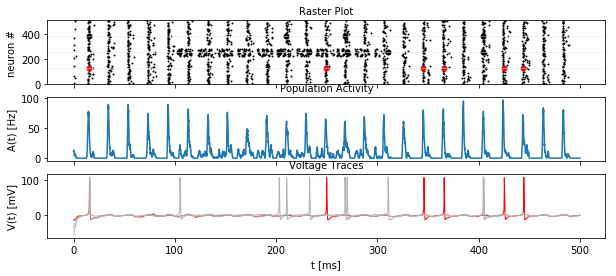

In [59]:
# Reduced model so mAChR is replaced with AMPA
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([10.89212943,  7.20597675,  8.09613807,  8.09613807, 48.7]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_EC_LV_Principal_Neurons_reduced(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

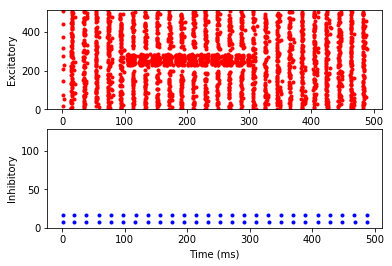

In [60]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13573a1d0>)

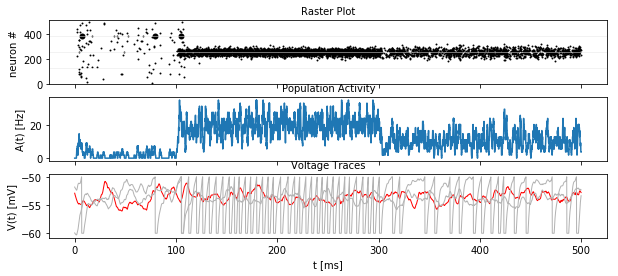

In [119]:
# Run the original simulate_wm with NMDA receptors/channels with default parameter values
weight_scaling_factor= 4.
stimulus_strength = 0.5*namp
#rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, Jpos_excit2excit=Jpos_excit2excit, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib)
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

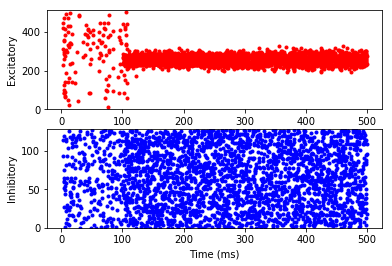

In [120]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d1ebb50>)

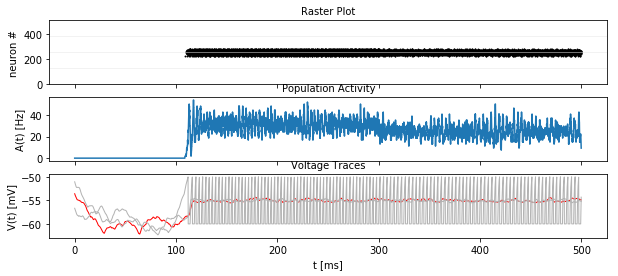

In [80]:
# Run simulate_wm with non default synaptic conductances
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([4.11196681, 4.11196681, 3.20004824, 4.11196681, 1.92852664]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)

plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

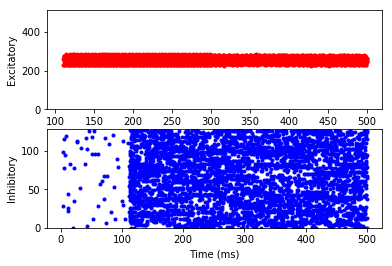

In [81]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13161e410>)

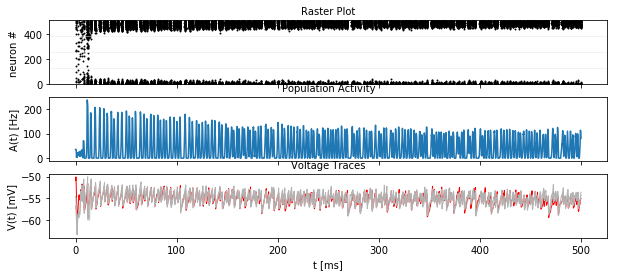

In [52]:
# Run simulate_wm_reduced Reduced model using AMPA channels only
weight_scaling_factor= 1.
stimulus_strength = 0.5*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([ 2.09711082, 31.45849158, 17.95217943, 30.91330191, 45.0980548 ]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_reduced(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

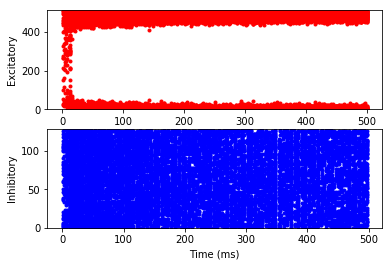

In [53]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')

(<Figure size 720x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123322fd0>)

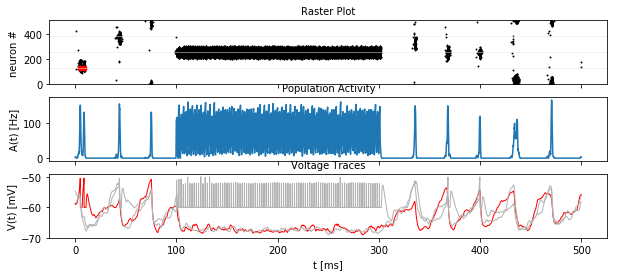

In [15]:
# Run simulate_wm_reduced2 Reduced model using AMPA channels only
weight_scaling_factor= 1.
stimulus_strength = 20.*namp
G_inhib2inhib, G_inhib2excit, G_excit2excit, G_excit2inhib, G_extern2excit = np.array([30.68446107, 22.10526499, 21.85452222, 15.62642328,  3.86240685]) * nS
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, weight_profile_45 = wm_model_modified_simplified_EC_LV_principal.simulate_wm_reduced2(sim_time=sim_time_duration, poisson_firing_rate=poisson_firing_rate, sigma_weight_profile=sigma_weight_profile, t_stimulus_start=t_stimulus_start, t_stimulus_duration=t_stimulus_duration, stimulus_center_deg=stimulus_center_deg,stimulus_width_deg=stimulus_width_deg,N_excitatory=N_excitatory,N_inhibitory=N_inhibitory,weight_scaling_factor=weight_scaling_factor,stimulus_strength=stimulus_strength, G_inhib2inhib=G_inhib2inhib, G_inhib2excit=G_inhib2excit, G_excit2excit=G_excit2excit, G_excit2inhib=G_excit2inhib, G_extern2excit=G_extern2excit)
plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * ms)

Text(0.5,0,u'Time (ms)')

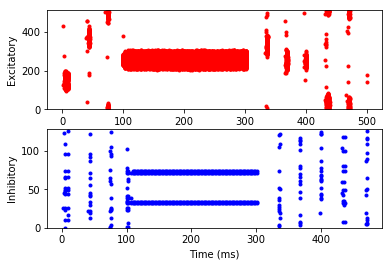

In [16]:
subplot(211)
plot(spike_monitor_excit.t/ms, spike_monitor_excit.i, '.r')
ylim([0,N_excitatory])
ylabel('Excitatory')
subplot(212)
plot(spike_monitor_inhib.t/ms, spike_monitor_inhib.i, '.b')
ylim([0,N_inhibitory])
ylabel('Inhibitory')
xlabel('Time (ms)')